In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
using Plots

In [4]:
n_x = 1
n_y = 10
n_vsa = 512

512

In [5]:
repeats = 6

6

In [6]:
phase_x = random_symbols((n_vsa, 1));

In [7]:
phase_z = random_symbols((n_vsa, 3));

In [8]:
phase_xp = random_symbols((n_vsa, 1));

In [9]:
phase_y = reduce(hcat, collect(range(start=phase_x, stop=phase_xp, length=n_y)));

In [10]:
sims = similarity(phase_x, phase_y)

1×10 Matrix{Float64}:
 1.0  0.961614  0.853594  0.695584  …  0.0933511  0.0376095  0.0205893

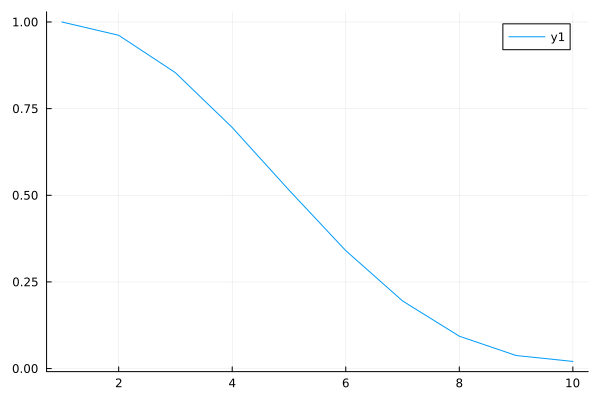

In [11]:
plot(sims |> vec)

In [12]:
similarity_self(phase_z, 2)

3×3 Matrix{Vector{Float64}}:
 [1.0]          [0.0145426]  [-0.00308318]
 [0.0145426]    [1.0]        [0.0129319]
 [-0.00308318]  [0.0129319]  [1.0]

In [13]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [14]:
st_x = phase_to_train(phase_x, spk_args, repeats = repeats)
st_y = phase_to_train(phase_y, spk_args, repeats = repeats)

Spike Train: (512, 10) with 30720 spikes.

In [15]:
tspan = (0.0, repeats*1.0)

(0.0, 6.0)

In [16]:
using OrdinaryDiffEq

In [17]:
sa = SpikingArgs()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.02 (V)


In [40]:
function similarity(x::SpikeTrain, y::SpikeTrain, dim::Int = 1; tspan::Tuple{<:Real, <:Real} = (0.0, 10.0), spk_args::SpikingArgs = default_spk_args(), return_solution::Bool = false)
    sol_x = phase_memory(x, tspan = tspan, spk_args = spk_args)
    sol_y = phase_memory(y, tspan = tspan, spk_args = spk_args)

    u_x = normalize_potential.(Array(sol_x))
    u_y = normalize_potential.(Array(sol_y))

    interference = abs.(u_x .+ u_y)
    magnitude = clamp.(interference, 0.0, 2.0)
    half_angle = acos.(0.5 .* magnitude)
    sim = cos.(2.0 .* half_angle)
    avg_sim = mean(sim, dims=dim)
    
    return avg_sim

end

similarity (generic function with 4 methods)

In [41]:
sim = similarity(st_x, st_y, 1, tspan=tspan, spk_args=sa, return_solution=true);

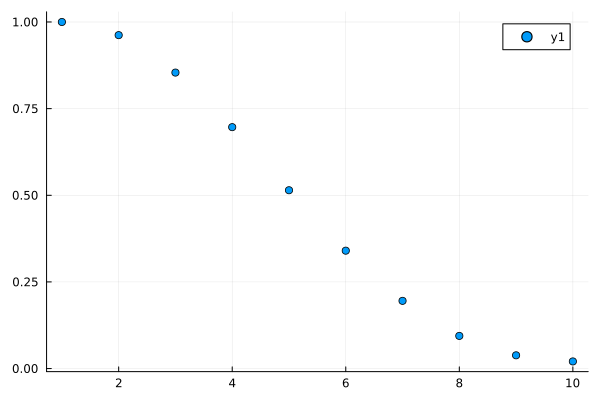

In [43]:
scatter(sim[1,:,end])

In [44]:
spk_sim = sim[1,:,end]

10-element Vector{Float64}:
 0.9999999748542909
 0.9620495202735749
 0.8540285446130467
 0.6965620465592018
 0.5145129365750996
 0.3401299151146599
 0.19536384442640192
 0.0941944887201651
 0.03818415416074227
 0.020548478511440118

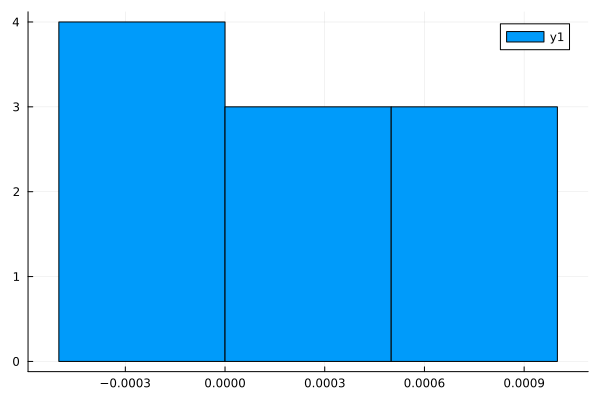

In [47]:
error = spk_sim .- vec(sims)
histogram(error)